## Import Libraries 

In this notebook we are going to try to classify the fake text using a logistic regression. 
You'll find : 
- A TF-IDF Matrix to extract features
- A Text Feature extraction

In [ ]:
import os
import pandas as pd
import numpy as np 
from langdetect import DetectorFactory
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
DetectorFactory.seed = 42
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re 
import nltk
nltk.download('stopwords')
import unicodedata

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading all the files

In [3]:
def read_texts_from_dir(dir_path:str) -> pd.DataFrame :
  """
  Reads the texts from a given directory and saves them in the pd.DataFrame with columns ['id', 'file_1', 'file_2'].

  Params:
    dir_path (str): path to the directory with data
  """
  dir_count = sum(os.path.isdir(os.path.join(root, d)) for root, dirs, _ in os.walk(dir_path) for d in dirs)
  data=[0 for _ in range(dir_count)]
  print(f"Number of directories: {dir_count}")

  # For each directory, read both file_1.txt and file_2.txt and save results to the list
  i=0
  for folder_name in sorted(os.listdir(dir_path)):
    folder_path = os.path.join(dir_path, folder_name)
    if os.path.isdir(folder_path):
      try:
        with open(os.path.join(folder_path, 'file_1.txt'), 'r', encoding='utf-8') as f1:
          text1 = f1.read().strip()
        with open(os.path.join(folder_path, 'file_2.txt'), 'r', encoding='utf-8') as f2:
          text2 = f2.read().strip()
        index = int(folder_name[-4:])
        data[i]=(index, text1, text2)
        i+=1
      except Exception as e:
        print(f"Error reading directory {folder_name}: {e}")
  df = pd.DataFrame(data, columns=['id', 'file_1', 'file_2']).set_index('id')
  return df

In [ ]:
# Load the training data
train_path = "../data/train"
train_data = read_texts_from_dir(train_path)

# Load the test data 
test_path="../data/test"
test_data=read_texts_from_dir(test_path)
ids = test_data.index.to_list()

In [11]:
train_data.head()

,file_1,file_2
id,,
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...


In [12]:
# Load the training ground truth labels
df_train_gt=pd.read_csv("../data/train.csv")
df_train_gt

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2
...,...,...
90,90,2
91,91,1
92,92,2
93,93,2


The class are balanced, so any model can learn from the two classes.

In [13]:
df_train_gt["real_text_id"].value_counts()


real_text_id
2    49
1    46
Name: count, dtype: int64

### Simple Exploratory Data Analysis

We perform this data analysis to see if a simple rule model could properly classify texts.

There are not difference between the length of text 1 and text 2 when they are true

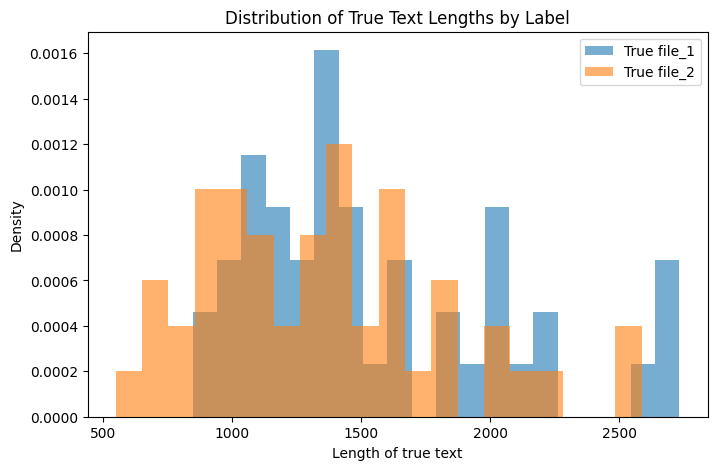

In [14]:
def plot_length_text_per_category(train_data:pd.DataFrame, ground_truth: pd.DataFrame)-> None:
  """
  Plots the length of texts in file_1 and file_2 when they are the true text.

  Params:
    train_data (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
    ground_truth (pd.DataFrame): DataFrame with columns ['id', 'real_text_id'].
  """
  merged_data = train_data.merge(ground_truth, left_index=True, right_on='id')

  df = merged_data.copy()
  df["true_text"] = df.apply(
      lambda row: row["file_1"] if row["real_text_id"] == 1 else row["file_2"], axis=1
  )
  df["true_length"] = df["true_text"].str.len()

  df_label1 = df[df["real_text_id"] == 1]
  df_label2 = df[df["real_text_id"] == 2]

  # These values are from value_counts() above
  assert df_label2.shape[0] == 49
  assert df_label1.shape[0] == 46

  plt.figure(figsize=(8, 5))
  plt.hist(df_label1["true_length"], bins=20, alpha=0.6, label="True file_1", density=True)
  plt.hist(df_label2["true_length"], bins=20, alpha=0.6, label="True file_2", density=True)

  plt.xlabel("Length of true text")
  plt.ylabel("Density")
  plt.title("Distribution of True Text Lengths by Label")
  plt.legend()
  plt.show()

plot_length_text_per_category(train_data, df_train_gt)

In [15]:
train_data.isnull().sum()

file_1    0
file_2    0
dtype: int64

In [16]:
train_data.duplicated().sum()

np.int64(0)

In [17]:
train_data.map(lambda x: [len(x), type(x.strip())])

,file_1,file_2
id,,
0,"[2196, <class 'str'>]","[2018, <class 'str'>]"
1,"[3124, <class 'str'>]","[936, <class 'str'>]"
2,"[1139, <class 'str'>]","[801, <class 'str'>]"
3,"[1774, <class 'str'>]","[1869, <class 'str'>]"
4,"[195, <class 'str'>]","[871, <class 'str'>]"
...,...,...
90,"[2281, <class 'str'>]","[2146, <class 'str'>]"
91,"[1986, <class 'str'>]","[2038, <class 'str'>]"
92,"[8925, <class 'str'>]","[1128, <class 'str'>]"


### Preprocess text

In [18]:
LEMMATIZER = WordNetLemmatizer()
def preprocess_text(text:str) -> str:
  """
  Preprocesses the text data by , converting to lowercase, lemmatizing, and removing stopwords.

  Params:
    dataframe (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
  
  Returns:
    pd.DataFrame: Preprocessed DataFrame.
  """

  text = text.lower()
  text = LEMMATIZER.lemmatize(text)
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])


### We will try a logistic regression on heuristics

In [19]:

def train_logistic_regression(train_data:pd.DataFrame, df_train_gt:pd.DataFrame) -> tuple:
    """
    Trains a logistic regression model to classify which of the two texts is real.

    Params:
    train_data (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
    df_train_gt (pd.DataFrame): DataFrame with columns ['id', 'real_text_id'].
    """
    merged_data = train_data.merge(df_train_gt, left_index=True, right_on='id')
    texts = merged_data["file_1"].tolist() + merged_data["file_2"].tolist()

    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_all = vectorizer.fit_transform(texts)

    n = len(merged_data)
    X1, X2 = X_all[:n], X_all[n:]   # split back into file_1 and file_2

    X = X1 - X2
    y = (merged_data["real_text_id"] == 1).astype(int)  # 1 if file_1 is real, 0 if file_2 is real

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    return clf, vectorizer


In [20]:
logistic_regression, tfidf_vectorizer = train_logistic_regression(train_data, df_train_gt)

Accuracy: 0.9310344827586207


### Predict on test data

In [21]:
test_texts = test_data["file_1"].tolist() + test_data["file_2"].tolist()

In [22]:
X_test = tfidf_vectorizer.transform(test_texts)

In [23]:
n = len(test_data)
X1, X2 = X_test[:n], X_test[n:] 
X = X1 - X2

In [24]:
y_pred = logistic_regression.predict(X)

In [25]:
tfidf_submission_df = pd.DataFrame({
    "id": ids,
    "real_text_id": y_pred
})


Althought this method gave us promising results in train data.  
The test has a score of 0.47150/1.

In [26]:
tfidf_submission_df.to_csv("../data/submission.csv", index=False)

### Manual Feature Extraction

These are our helpers functions

In [48]:
def get_digit_ratio(text):
    """Calculate the ratio of numeric digits to total characters in the text."""
    return sum(c.isdigit() for c in text) / max(len(text), 1)

def get_upper_ratio(text):
    """Calculate the ratio of uppercase letters to total characters in the text."""
    return sum(c.isupper() for c in text) / max(len(text), 1)

def avg_word_length(text):
    """Calculate the average length of words in the text."""
    words = re.findall(r'\b\w+\b', text)
    return np.mean([len(w) for w in words]) if words else 0

def vocab_size(text):
    """Count the number of unique words in the text (case-insensitive)."""
    words = re.findall(r'\b\w+\b', text.lower())
    return len(set(words))

def punct_ratio(text):
    """Calculate the ratio of punctuation marks to total characters in the text."""
    return sum(1 for c in text if c in '-#&@]}<{^.,;:!?*') / max(len(text), 1)

def rare_word_ratio(text, common_words):
    """Calculate the ratio of rare words (not in common_words set) to total words."""
    words = re.findall(r'\b\w+\b', text.lower())
    rare = [w for w in words if w not in common_words]
    return len(rare) / max(len(words), 1) if words else 0

def sent_len_std(text):
    """Calculate the standard deviation of sentence lengths (in words) in the text."""
    sentences = re.split(r'[.!?]', text)
    lens = [len(s.split()) for s in sentences if s.strip()]
    return np.std(lens) if lens else 0

def repetition_score(text, n=3):
    """Calculate the ratio of repeated n-grams to total n-grams in the text."""
    words = text.lower().split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    counts = {}
    for ng in ngrams:
        counts[ng] = counts.get(ng, 0) + 1
    repeated = sum(1 for v in counts.values() if v > 1)
    return repeated / max(len(ngrams), 1) if ngrams else 0

def is_latin_char(char):
    """Detect if given character is from Latin alphabet."""
    char=str(char)
    try:
        name=unicodedata.name(char)
        return 'LATIN' in name
    except ValueError:
        return False

def num_of_latin_char(text)-> int:
    """Count the total number of Latin alphabet characters in the text."""
    count = 0
    for char in text:
        if is_latin_char(char):
            count += 1
    return count

def num_of_stop_words(text)-> int:
    """Count the number of English stop words in the text."""
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(1 for w in words if w in stop_words)

We compute the difference between file_1 and file_2 because we do a pairwise comparison.   
Unlike a single text classification, we are making a relative judgment on the two texts.

In [ ]:
def get_features(row):
    feats = {}
    t1, t2 = row['file_1'], row['file_2']

    # Length difference
    feats['len_diff'] = len(t1) - len(t2)
    # Sentence count difference
    feats['sent_diff'] = t1.count('.') - t2.count('.')
    # Digit ratio difference
    feats['digit_diff'] = get_digit_ratio(t1) - get_digit_ratio(t2)
    # Uppercase ratio difference
    feats['upper_diff'] = get_upper_ratio(t1) - get_upper_ratio(t2)
    # Average word length diff
    feats['avg_wordlen_diff'] = avg_word_length(t1) - avg_word_length(t2)
    # Vocabulary size diff
    feats['vocab_diff'] = vocab_size(t1) - vocab_size(t2)
    # Punctuation ratio diff
    feats['punct_diff'] = punct_ratio(t1) - punct_ratio(t2)
    # Sentence length std diff
    feats['sentlen_std_diff'] = sent_len_std(t1) - sent_len_std(t2)
    # Num of latin char diff 
    feats['num_latin_char_diff'] = num_of_latin_char(t1) - num_of_latin_char(t2)
    # Stop words count diff
    feats['stop_words_count_diff'] = num_of_stop_words(t1) - num_of_stop_words(t2)

    return pd.Series(feats)

We can now extract the features

In [ ]:
X = train_data.apply(get_features, axis=1)
y = (df_train_gt['real_text_id'] == 1).astype(int)  # 1 if file_1 is real, else 0

c:\Users\carlf\anaconda3\envs\kaggle\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.75      0.86        12

    accuracy                           0.84        19
   macro avg       0.85      0.88      0.84        19
weighted avg       0.89      0.84      0.84        19

Confusion Matrix:
 [[7 0]
 [3 9]]


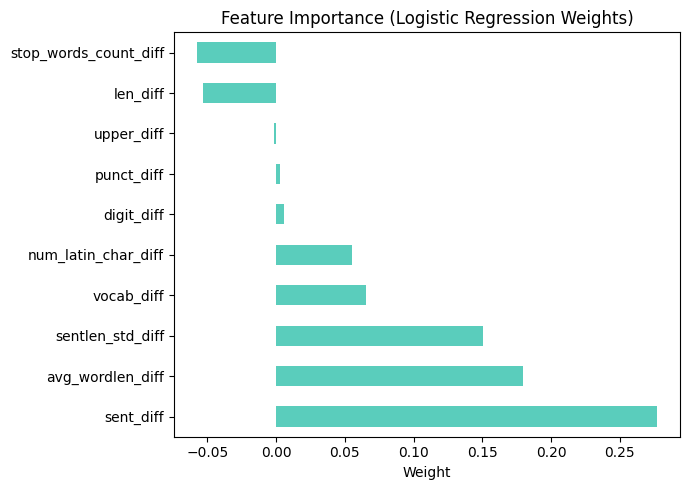

In [50]:
# Split into train and validation sets for a quick sanity check
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit interpretable logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Show feature importances
feature_importance = pd.Series(clf.coef_[0], index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh', figsize=(7,5), color="#5ACDBC")
plt.title("Feature Importance (Logistic Regression Weights)")
plt.xlabel("Weight")
plt.tight_layout()
plt.show()

In [46]:
# Extract features for the test set
X_test = test_data.apply(get_features, axis=1)
# Predict: 1 if file_1 is real, 0 if file_2 is real
test_preds = clf.predict(X_test)
df_submission = pd.DataFrame({
    'id':ids,
    'real_text_id': [1 if pred == 1 else 2 for pred in test_preds]
})
df_submission.to_csv('../data/logistic_regression_submission.csv', index=False)